In [ ]:
!pip install optuna

import os
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from scipy.signal import savgol_filter

BASE_EXTRACTED = Path(
    "/content/drive/MyDrive/4 month project/DataSet/Extracted Files"
)

BASE_PREPRO = Path(
    "/content/drive/MyDrive/4 month project/DataSet/Processed Files"
)
BASE_PREPRO.mkdir(parents=True, exist_ok=True)

print("Extracted exists:", BASE_EXTRACTED.exists())

Extracted exists: True


In [ ]:
INITIAL_CAP_CYCLES = 5
SAVGOL_WINDOW = 11
SAVGOL_POLY = 3

MIN_POINTS_PER_CYCLE = 5
MIN_DISCHARGE_TIME_SEC = 1.0
EOL_SOHPCT = 80.0

def safe_read_csv(path):
    try:
        return pd.read_csv(path)
    except:
        return pd.read_csv(path, engine="python", encoding="latin1")


def parse_time_column(s):
    arr = pd.to_numeric(s, errors="coerce").values
    if np.isnan(arr).all():
        return np.arange(len(arr)).astype(float)
    return arr.astype(float)


def smooth_signal(ar):
    ar = np.array(ar, dtype=float)
    if len(ar) < 5 or np.isnan(ar).all():
        return ar
    w = min(SAVGOL_WINDOW, len(ar)//2*2+1)
    try:
        return savgol_filter(ar, w, SAVGOL_POLY)
    except:
        return ar


def compute_capacity_from_current(time_s, current):
    if len(time_s) < 2:
        return np.nan
    dt = np.diff(time_s)
    if np.any(dt <= 0):
        return np.nan
    return abs(np.sum(current[:-1] * dt) / 3600)

def load_and_clean_discharge(path):
    df = safe_read_csv(path)
    df.columns = [c.lower() for c in df.columns]

    return pd.DataFrame({
        "time_s": parse_time_column(df.iloc[:, 0]),
        "voltage": smooth_signal(pd.to_numeric(df.filter(like='voltage').iloc[:,0], errors='coerce')),
        "current": smooth_signal(pd.to_numeric(df.filter(like='current').iloc[:,0], errors='coerce')),
        "temperature": pd.to_numeric(df.filter(like='temp').iloc[:,0], errors='coerce'),
        "cycle_no": pd.to_numeric(df.filter(like='cycle').iloc[:,0], errors='coerce')
    })


def load_and_clean_charge(path):
    df = safe_read_csv(path)
    df.columns = [c.lower() for c in df.columns]

    return pd.DataFrame({
        "cycle_no": pd.to_numeric(df.filter(like='cycle').iloc[:,0], errors='coerce'),
        "chg_voltage_mean": pd.to_numeric(df.filter(like='voltage').iloc[:,0], errors='coerce'),
        "chg_current_mean": pd.to_numeric(df.filter(like='current').iloc[:,0], errors='coerce'),
        "chg_temp_mean": pd.to_numeric(df.filter(like='temp').iloc[:,0], errors='coerce'),
    })


def load_and_clean_impedance(path):
    df = safe_read_csv(path)
    df.columns = [c.lower() for c in df.columns]

    r_real = pd.to_numeric(df.filter(like='re').iloc[:,0], errors='coerce')
    r_imag = pd.to_numeric(df.filter(like='im').iloc[:,0], errors='coerce')

    return pd.DataFrame({
        "cycle_no": pd.to_numeric(df.filter(like='cycle').iloc[:,0], errors='coerce'),
        "ir_real_mean": r_real,
        "ir_imag_mean": r_imag,
        "z_mag_mean": np.sqrt(r_real**2 + r_imag**2)
    })

In [ ]:
def discover_batteries(base_dir):
    batteries = {}

    for subdir in base_dir.iterdir():
        if not subdir.is_dir():
            continue

        csvs = list(subdir.glob("*.csv"))
        if len(csvs) == 0:
            continue

        temp = {}
        for p in csvs:
            parts = p.name.split("_")
            if len(parts) < 2:
                continue
            bid = parts[0]
            ftype = parts[1].replace(".csv", "").lower()
            temp.setdefault(bid, {})[ftype] = p

        for bid, files in temp.items():
            if all(k in files for k in ["charge","discharge","impedance"]):
                batteries[bid] = files

    return batteries


batteries = discover_batteries(BASE_EXTRACTED)
print("Total batteries:", len(batteries))

def aggregate_discharge_cycles(df):
    rows = []
    for cyc, g in df.groupby("cycle_no"):
        if len(g) < MIN_POINTS_PER_CYCLE:
            continue

        t = g["time_s"].iloc[-1] - g["time_s"].iloc[0]
        if t < MIN_DISCHARGE_TIME_SEC:
            continue

        cap = compute_capacity_from_current(g["time_s"].values, g["current"].values)

        rows.append({
            "cycle_no": int(cyc),
            "capacity_Ah": cap,
            "discharge_time_sec": t,
            "voltage_mean": g["voltage"].mean(),
            "voltage_min": g["voltage"].min(),
            "voltage_max": g["voltage"].max(),
            "temp_mean": g["temperature"].mean()
        })

    return pd.DataFrame(rows).sort_values("cycle_no")

def identify_reference_cycles(df):
    """
    Identify reference (RPT) discharge cycles based on discharge duration.
    Reference cycles are typically longer and more stable.
    """

    # Compute discharge duration statistics
    t = df["discharge_time_sec"]

    # Reference cycles: long-duration discharges
    # Threshold chosen empirically (can be justified in report)
    ref_threshold = t.quantile(0.75)

    df["is_reference"] = (t >= ref_threshold).astype(int)
    return df

Total batteries: 34


In [ ]:
def align_modalities(discharge_df, charge_df, imp_df):
    base = discharge_df.copy()

    # sort
    charge_df = charge_df.sort_values("cycle_no")
    imp_df = imp_df.sort_values("cycle_no")

    # forward-fill alignment (nearest previous)
    base = pd.merge_asof(
        base.sort_values("cycle_no"),
        charge_df,
        on="cycle_no",
        direction="backward"
    )

    base = pd.merge_asof(
        base.sort_values("cycle_no"),
        imp_df,
        on="cycle_no",
        direction="backward"
    )

    return base

def compute_reference_soh(df):
    df = df.sort_values("cycle_no").reset_index(drop=True)

    # Only reference cycles are trusted for capacity
    ref_df = df[df["is_reference"] == 1]

    # Remove physically invalid reference cycles
    ref_df = ref_df[
        (ref_df["capacity_Ah"] > 0.05) &          # remove zero / noise
        (ref_df["capacity_Ah"] < 1.2 * ref_df["capacity_Ah"].median())
    ]

    if ref_df.empty:
        # No reference cycles for this battery
        df["SOH"] = np.nan
        df["RUL"] = np.nan
        df["is_reference"] = 0
        return df

    init_cap = ref_df.sort_values("cycle_no")["capacity_Ah"].iloc[:INITIAL_CAP_CYCLES].mean()

    # Compute SOH only for reference cycles
    df["SOH"] = np.nan
    df.loc[df["is_reference"] == 1, "SOH"] = (
        df.loc[df["is_reference"] == 1, "capacity_Ah"] / init_cap
    ) * 100

    # Forward-fill SOH to non-reference cycles
    df["SOH"] = df["SOH"].ffill()
    df["SOH"] = df["SOH"].clip(upper=100)

    # EOL detection
    eol_cycles = df[df["SOH"] <= EOL_SOHPCT]["cycle_no"]
    eol_cycle = eol_cycles.iloc[0] if not eol_cycles.empty else df["cycle_no"].max()

    df["RUL"] = (eol_cycle - df["cycle_no"]).clip(lower=0)

    return df

In [ ]:
all_cycles = []

for bid, files in tqdm(batteries.items()):
    d_raw = load_and_clean_discharge(files["discharge"])
    c_raw = load_and_clean_charge(files["charge"])
    i_raw = load_and_clean_impedance(files["impedance"])

    d_cyc = aggregate_discharge_cycles(d_raw)
    if d_cyc.empty:
        continue

    aligned = align_modalities(d_cyc, c_raw, i_raw)
    aligned = identify_reference_cycles(aligned)
    aligned = compute_reference_soh(aligned)
    aligned["battery_id"] = bid

    aligned.to_csv(BASE_PREPRO / f"{bid}_multimodal_cycles.csv", index=False)
    all_cycles.append(aligned)

master = pd.concat(all_cycles).reset_index(drop=True)
master.to_csv(BASE_PREPRO / "all_batteries_multimodal_processed.csv", index=False)

print("Cycle-level multimodal data saved.")

df = master.sort_values(["battery_id","cycle_no"]).reset_index(drop=True)

# DO NOT fill yet
df = df.replace([np.inf, -np.inf], np.nan)

# degradation features
df["cap_delta"] = df.groupby("battery_id")["capacity_Ah"].diff()
df["cap_delta_roll5"] = df.groupby("battery_id")["cap_delta"].rolling(5,1).mean().reset_index(level=0,drop=True)

df["cycle_frac"] = df.groupby("battery_id")["cycle_no"].transform(
    lambda x:(x-x.min())/(x.max()-x.min()+1e-6)
)

df["ir_real_delta"] = df.groupby("battery_id")["ir_real_mean"].diff()

# presence flags (CRITICAL)
df["has_charge"] = (~df["chg_voltage_mean"].isna()).astype(int)
df["has_impedance"] = (~df["ir_real_mean"].isna()).astype(int)

# safe fill AFTER flags
charge_cols = ["chg_voltage_mean","chg_current_mean","chg_temp_mean"]
imp_cols = ["ir_real_mean","ir_imag_mean","z_mag_mean","ir_real_delta"]

df[charge_cols] = df[charge_cols].fillna(0.0)
df[imp_cols] = df[imp_cols].fillna(0.0)

df = df.fillna(0.0)

df.to_csv(BASE_PREPRO / "all_batteries_features_engineered.csv", index=False)
print("Final ML-ready dataset saved.")

100%|██████████| 34/34 [00:17<00:00,  1.90it/s]


Cycle-level multimodal data saved.
Final ML-ready dataset saved.


In [ ]:
valid_batteries = []

for bid, sub in master.groupby('battery_id'):
    if (sub['SOH'] > EOL_SOHPCT).any():
        valid_batteries.append(bid)

df = master[master['battery_id'].isin(valid_batteries)]

print(len(valid_batteries))

33


In [ ]:
df[df['RUL']==0]['SOH'].describe()

,SOH
count,889.000000
mean,85.394857
std,17.274949
min,0.000000
25%,80.387902
50%,87.114121
75%,100.000000
max,100.000000


In [ ]:
df = pd.read_csv(BASE_PREPRO / "all_batteries_features_engineered.csv")

print(df["has_charge"].value_counts())
print(df["has_impedance"].value_counts())

df[["chg_voltage_mean","ir_real_mean"]].describe()

has_charge
1    2769
0      23
Name: count, dtype: int64
has_impedance
1    2716
0      76
Name: count, dtype: int64


,chg_voltage_mean,ir_real_mean
count,2792.000000,2792.000000
mean,3.861036,24.435530
std,0.543184,6.015816
min,0.000000,0.000000
25%,3.756302,24.000000
50%,3.939667,24.000000
75%,4.187423,24.000000
max,4.983665,43.000000


count    2792.000000
mean       84.662664
std        24.595024
min         0.000000
25%        82.963875
50%        91.354187
75%        97.409663
max       100.000000
Name: SOH, dtype: float64
0
is_reference
0    2085
1     707
Name: count, dtype: int64


<Axes: xlabel='cycle_no'>

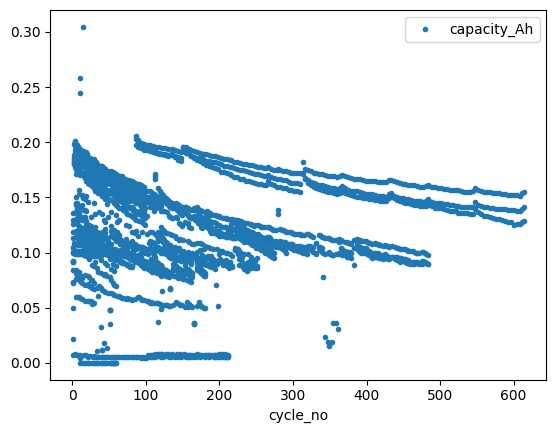

In [ ]:
df = pd.read_csv(BASE_PREPRO / "all_batteries_features_engineered.csv")

# 1. SOH sanity
print(df["SOH"].describe())

# 2. No SOH > 100
print((df["SOH"] > 100).sum())

# 3. Reference cycles exist
print(df["is_reference"].value_counts())

# 4. Capacity spikes isolated to reference cycles
df.plot(x="cycle_no", y="capacity_Ah", style=".")

count    2792.000000
mean       84.662664
std        24.595024
min         0.000000
25%        82.963875
50%        91.354187
75%        97.409663
max       100.000000
Name: SOH, dtype: float64
SOH > 100: 0
Batteries with SOH: battery_id
B0005    True
B0006    True
B0007    True
B0018    True
B0025    True
B0026    True
B0027    True
B0028    True
B0029    True
B0030    True
B0031    True
B0032    True
B0033    True
B0034    True
B0036    True
B0038    True
B0039    True
B0040    True
B0041    True
B0042    True
B0043    True
B0044    True
B0045    True
B0046    True
B0047    True
B0048    True
B0049    True
B0050    True
B0051    True
B0052    True
B0053    True
B0054    True
B0055    True
B0056    True
Name: SOH, dtype: bool
Total SOH rows: 2792
SOH > 100: 0


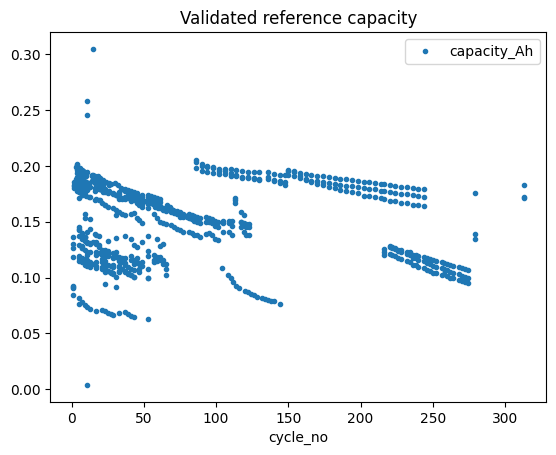

In [ ]:
df = pd.read_csv(BASE_PREPRO / "all_batteries_features_engineered.csv")

print(df["SOH"].describe())
print("SOH > 100:", (df["SOH"] > 100).sum())

df[df["is_reference"] == 1].plot(
    x="cycle_no", y="capacity_Ah", style=".", title="Validated reference capacity"
)

print("Batteries with SOH:", df.groupby("battery_id")["SOH"].apply(lambda x: x.notna().any()))
print("Total SOH rows:", df["SOH"].notna().sum())
print("SOH > 100:", (df["SOH"] > 100).sum())

In [ ]:
raw_ids = set(batteries.keys())
final_ids = set(df["battery_id"].unique())

print("Dropped batteries:", sorted(raw_ids - final_ids))
print("Kept batteries:", sorted(final_ids))

Dropped batteries: []
Kept batteries: ['B0005', 'B0006', 'B0007', 'B0018', 'B0025', 'B0026', 'B0027', 'B0028', 'B0029', 'B0030', 'B0031', 'B0032', 'B0033', 'B0034', 'B0036', 'B0038', 'B0039', 'B0040', 'B0041', 'B0042', 'B0043', 'B0044', 'B0045', 'B0046', 'B0047', 'B0048', 'B0049', 'B0050', 'B0051', 'B0052', 'B0053', 'B0054', 'B0055', 'B0056']
